In [6]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple

import importlib
import utils.preprocess
import utils.baseline
import utils.model
importlib.reload(utils.preprocess)
importlib.reload(utils.baseline)
importlib.reload(utils.model)

from utils.preprocess import DataWindow
from utils.model import AutoRegressive, ModelTrainer

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

In [2]:
# データのダウンロード
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

In [3]:
# モデルのコンパイルと訓練を行う関数を定義
def compile_and_fit(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                    criterion: nn.Module, optimizer: optim.Optimizer, 
                    device: torch.device, max_epochs: int = 50, patience: int = 3) -> Dict[str, List[float]]:
    """
    モデルのコンパイルとトレーニング。

    引数:
        model (nn.Module): 学習モデル。
        train_loader (DataLoader): 訓練データローダー。
        val_loader (DataLoader): 検証データローダー。
        criterion (nn.Module): 損失関数。
        optimizer (optim.Optimizer): オプティマイザ。
        device (torch.device): 実行環境。
        max_epochs (int): 最大エポック数。
        patience (int): 早期停止のエポック数。

    戻り値:
        Dict[str, List[float]]: トレーニングおよび検証損失の履歴。
    """
    trainer = ModelTrainer(model, train_loader, val_loader, criterion, optimizer, device)
    return trainer.train(max_epochs=max_epochs, patience=patience)

# モデルの評価関数を定義
def evaluate(model: nn.Module, data_loader: DataLoader, criterion: nn.Module, device: torch.device) -> float:
    """
    モデルの評価関数。

    引数:
        model (nn.Module): 学習済みモデル。
        data_loader (DataLoader): データローダー。
        criterion (nn.Module): 損失関数。
        device (torch.device): 実行環境。

    戻り値:
        float: 評価損失。
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# モデルの設定
INPUT_DIM = 5
OUTPUT_DIM_SINGLE = 1
OUTPUT_DIM_MULTI = 2
HIDDEN_DIM = 32
KERNEL_WIDTH = 3
LABEL_WIDTH = 24 # プロット用に設定
INPUT_WIDTH = 24
loss_criterion = nn.MSELoss()
val_criterion = nn.L1Loss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 17. 予測を使ってさらに予測を行う

## 17.2 ARLSTMモデルを構築する

In [4]:
# マルチステップモデル用のデータウィンドウの作成（24時間分の入力から次の24時間の交通量を予測するモデル）
multi_window = DataWindow(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=24,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

# dataloaderの作成
train_dataloader = multi_window.train
val_dataloader = multi_window.val
test_dataloader = multi_window.test

Epoch 1/50, Train Loss: 0.0771, Val Loss: 0.0349
Epoch 2/50, Train Loss: 0.0278, Val Loss: 0.0264
Epoch 3/50, Train Loss: 0.0234, Val Loss: 0.0263
Epoch 4/50, Train Loss: 0.0220, Val Loss: 0.0225
Epoch 5/50, Train Loss: 0.0212, Val Loss: 0.0218
Epoch 6/50, Train Loss: 0.0207, Val Loss: 0.0212
Epoch 7/50, Train Loss: 0.0201, Val Loss: 0.0206
Epoch 8/50, Train Loss: 0.0196, Val Loss: 0.0210
Epoch 9/50, Train Loss: 0.0191, Val Loss: 0.0213
Epoch 10/50, Train Loss: 0.0186, Val Loss: 0.0194
Epoch 11/50, Train Loss: 0.0182, Val Loss: 0.0191
Epoch 12/50, Train Loss: 0.0180, Val Loss: 0.0189
Epoch 13/50, Train Loss: 0.0176, Val Loss: 0.0187
Epoch 14/50, Train Loss: 0.0174, Val Loss: 0.0186
Epoch 15/50, Train Loss: 0.0174, Val Loss: 0.0183
Epoch 16/50, Train Loss: 0.0170, Val Loss: 0.0182
Epoch 17/50, Train Loss: 0.0170, Val Loss: 0.0192
Epoch 18/50, Train Loss: 0.0167, Val Loss: 0.0178
Epoch 19/50, Train Loss: 0.0165, Val Loss: 0.0180
Epoch 20/50, Train Loss: 0.0166, Val Loss: 0.0199
Epoch 21/

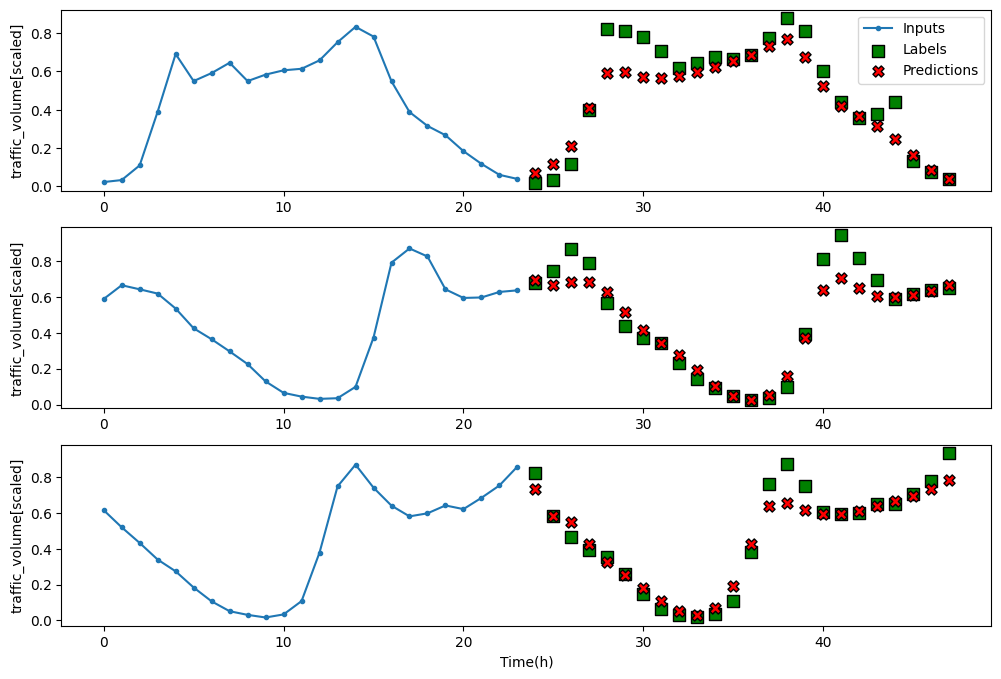

In [7]:
# モデルの訓練
model = AutoRegressive(
    units=32,
    out_steps=24,
    input_dim=INPUT_DIM
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          loss_criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, val_criterion, device)
test_loss = evaluate(model, test_dataloader, val_criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

# 予測値の可視化
multi_window.plot(model)